In [15]:
# Timothy Bender
# CSCI 347 Final Project 
# April 11, 2021


# Data preprocessing and tensforflow/keras model training for the wine quality dataset to predict wine quality. 

import numpy as np
import tensorflow as tf 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as t
from tensorflow.keras.models import save_model

file = 'winequality-red.csv'
DATA = pd.read_csv(file)



In [16]:
print(DATA.shape)
print(DATA.head)
DATA.info()

(1599, 12)
<bound method NDFrame.head of       fixed acidity  volatile acidity  citric acid  ...  sulphates  alcohol  quality
0               7.4             0.700         0.00  ...       0.56      9.4        5
1               7.8             0.880         0.00  ...       0.68      9.8        5
2               7.8             0.760         0.04  ...       0.65      9.8        5
3              11.2             0.280         0.56  ...       0.58      9.8        6
4               7.4             0.700         0.00  ...       0.56      9.4        5
...             ...               ...          ...  ...        ...      ...      ...
1594            6.2             0.600         0.08  ...       0.58     10.5        5
1595            5.9             0.550         0.10  ...       0.76     11.2        6
1596            6.3             0.510         0.13  ...       0.75     11.0        6
1597            5.9             0.645         0.12  ...       0.71     10.2        5
1598            6.0     

In [26]:
# We will begin our data exploration by looking for attributes with very high correlations. 

pairplot = sns.pairplot(DATA, hue='quality')
pairplot.savefig('pairplot.png')

Output hidden; open in https://colab.research.google.com to view.

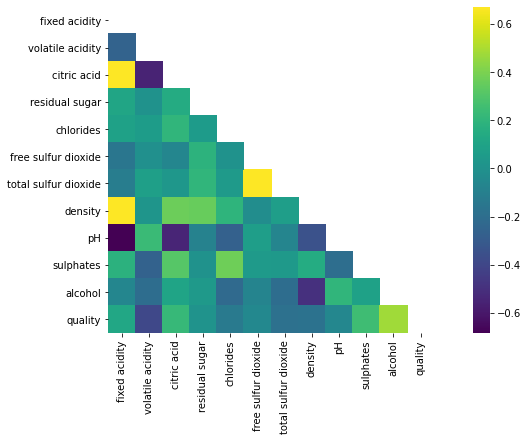

In [17]:
# It appears that we have some attributes with a high correlation. Lets confirm this visually via a seaborne heatmap. 

mask = np.zeros_like(DATA.corr())
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(14,6))
sns.heatmap(DATA.corr(), cmap = 'viridis', mask=mask, annot=False, square=True)


In [18]:
# The heatmap confirms our fears that density/citric acid has a high correlation with fixed acidity, and that
# total sulfur dioxide has a high correlation with free sulfur dioxide which is no surprise. 
# Lets now plot the correlation between these three attributes, and view which instances are greater than .6 (very high)
(abs(DATA.corr()[['fixed acidity', 'volatile acidity', 'total sulfur dioxide']])> .6) * 1


,fixed acidity,volatile acidity,total sulfur dioxide
fixed acidity,1,0,0
volatile acidity,0,1,0
citric acid,1,0,0
residual sugar,0,0,0
chlorides,0,0,0
free sulfur dioxide,0,0,1
total sulfur dioxide,0,0,1
density,1,0,0
pH,1,0,0
sulphates,0,0,0


In [19]:
# Now for our pre-processing, we will begin by dropping several attributes which we previously
# saw to have very high correlations

data = DATA.drop(columns=['citric acid', 'density', 'pH', 'total sulfur dioxide'])
data.head()

,fixed acidity,volatile acidity,residual sugar,chlorides,free sulfur dioxide,sulphates,alcohol,quality
0,7.4,0.70,1.9,0.076,11.0,0.56,9.4,5
1,7.8,0.88,2.6,0.098,25.0,0.68,9.8,5
2,7.8,0.76,2.3,0.092,15.0,0.65,9.8,5
3,11.2,0.28,1.9,0.075,17.0,0.58,9.8,6
4,7.4,0.70,1.9,0.076,11.0,0.56,9.4,5


With our data now pre-processed we can begin splitting our data into training and testing data. From experimentation, it seems that the apppropriate test_size is approximately 15%. A high training size helped to prevent future overfitting. 

In [20]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

X = data.loc[:, data.columns != 'quality'].values
y = data.quality.values
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=40)

# Our Y train and test are categorical attributes, namely (0-bad, 1-good)
y_train_cat = to_categorical(y_train, 6)
y_test_cat = to_categorical(y_test, 6)


I will now use a scalar to furthur transform the data

In [21]:
scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(1359, 7)
(240, 7)


With our data now separated into its constituent components, we can begin creating our keras model. Through lots of experimentation 4 Dense layers using a relu activation function fit the data the best. From there, we pass it through an equally sized Dense layer using a sigmoid activation function to fit the data into our categories. I could have used a arctan activation function but the sigmoid appears to be better suited.

From there I compiled the model, using the adam optimizer, since it the most commonly used for classification training, with a loss function of categorical crossentropy. I finally decided to track the accuracy metric to evaluate our model later. 

In [22]:
ben_init = tf.keras.initializers.GlorotNormal()

model = Sequential()
model.add(Dense(48, kernel_initializer=ben_init,  activation='relu'))
model.add(Dense(24, kernel_initializer=ben_init, activation='relu'))
model.add(Dense(12, kernel_initializer=ben_init, activation='relu'))
model.add(Dense(6, kernel_initializer=ben_init,
activation='relu'))
model.add(Dense(6, kernel_initializer=ben_init, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Originally I trained the model with 30 epochs, but noticed that the model began overfitting the loss function and diverging at ~ 22 epochs.

In [23]:
model.fit(X_train,
y_train_cat, epochs=22,validation_data=(X_test, y_test_cat), verbose=0)

After much experimentation, the model does an excellent job at fitting the loss function and learns as accurately as can be expected. This model achieves approximately 62.5% accuracy. To push this higher, a more robust training dataset with lower covariance attributes would likely be needed. 

['loss', 'accuracy']
[0.9426518678665161, 0.625]


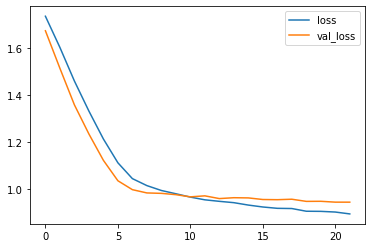

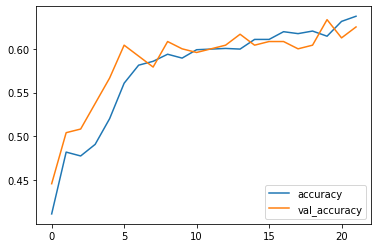

In [24]:
losses = pd.DataFrame(model.history.history)

losses[['loss','val_loss']].plot()
losses[['accuracy','val_accuracy']].plot()

print(model.metrics_names)
print(model.evaluate(X_test,y_test_cat,verbose=0))


In [25]:
# Save the model for future use. 
save_model(model, 'wine_model')

INFO:tensorflow:Assets written to: wine_model/assets
